In [241]:
import cv2

import os
from os.path import exists
import pandas as pd
import numpy as np
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from skimage.segmentation import active_contour
import cv2 as cv
from skimage.segmentation import clear_border
from skimage.filters import try_all_threshold

# Import packages for image processing
from skimage import morphology, filters #for measuring things in the masks

ImageFile.LOAD_TRUNCATED_IMAGES = True

import csv
import random 

A typical image would be path "..\data\images_resized\PAT_70_107_591.png"

In [242]:
# locate file
file_data = '..' + os.sep + 'data' + os.sep +'metadata.csv'
path_image = '..' + os.sep + 'data' + os.sep + 'images' + os.sep + 'imgs_part_1'

Literature on Gaussian smoothing:
https://medium.com/jun94-devpblog/cv-2-gaussian-and-median-filter-separable-2d-filter-2d11ee022c66

In [259]:
def preprocess_image(image_path):
    # Load the image
    img = cv2.imread(image_path)

    # # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply a Gaussian blur to the grayscale to smooth out any noise
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Normalize the color channels, scales the pixel values between 0 and 255
    norm = cv2.normalize(blur, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # Enhance the contrast of the normalized image using the Contrast Limited Adaptive Histogram Equalization (CLAHE) algorithm
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(norm)

    return enhanced

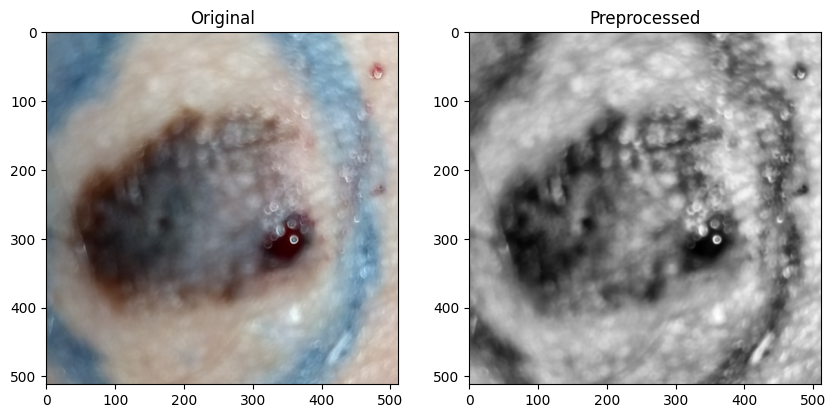

In [305]:
# Call the function to preprocess the image
# image_path = "..\\data\\images_resized\\PAT_70_107_591.png"
image_path = "..\\data\\images_resized\\PAT_70_107_155.png"
preprocessed_image = preprocess_image(image_path)

# Display the original and preprocessed images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
ax[0].set_title("Original")
ax[1].imshow(preprocessed_image, cmap="gray")
ax[1].set_title("Preprocessed")
plt.show()

In [306]:
def preprocess_image_util(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through all the image files in the input folder
    for file_name in os.listdir(input_folder):
        if file_name.endswith('.jpg') or file_name.endswith('.jpeg') or file_name.endswith('.png'):
            # Preprocess the image
            image_path = os.path.join(input_folder, file_name)
            preprocessed_image = preprocess_image(image_path)

            # Save the preprocessed image to the output folder
            output_path = os.path.join(output_folder, file_name)
            cv2.imwrite(output_path, preprocessed_image)

In [262]:
input_folder = '..\\data\\shanon_training'
output_folder = '..\\data\\shanon_training_output'
preprocess_image_util(input_folder, output_folder)

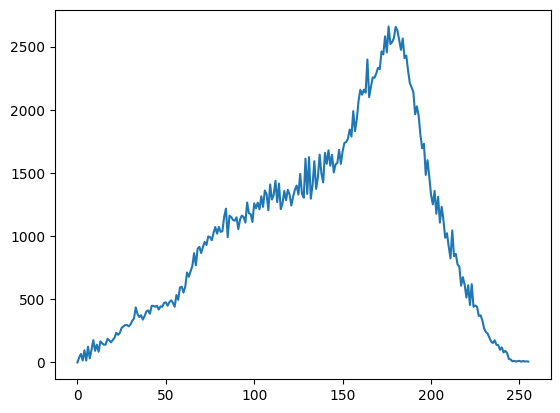

In [263]:
# Image intensity histogram

im_hist = cv2.calcHist([preprocessed_image], [0], None, [256], [0, 256])
plt.plot(im_hist)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


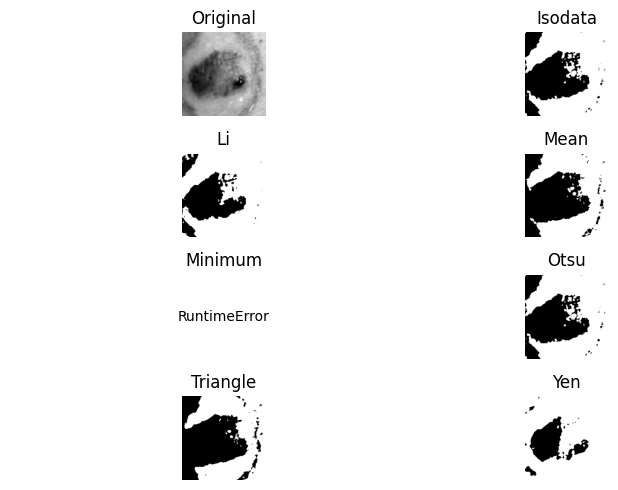

In [307]:
import skimage.filters

# Load the image
image_path = "..\\data\\images_resized\\PAT_70_107_155.png"
img = cv2.imread(image_path)

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply median filtering to the grayscale image
median_filtered = skimage.filters.median(gray)

# Use try_all_threshold to determine the optimal thresholding method
result = skimage.filters.thresholding.try_all_threshold(median_filtered)


In [337]:
def create_mask(img):
    # Check if input image is grayscale or color
    if len(img.shape) == 2:  # Grayscale image
        gray = img
    else:  # Color image
        # Convert the input image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Otsu's thresholding method to obtain a binary image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply morphological operations to clean up the binary image
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

    # Apply connected components analysis to obtain the mask
    connectivity = 8
    _, labels, stats, _ = cv2.connectedComponentsWithStats(closing, connectivity, cv2.CV_32S)

    # Get the index of the largest connected component (which should correspond to the lesion)
    largest_component = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1

    # Create a binary mask for the lesion
    mask = np.uint8(labels == largest_component)
    
    # # Check if the mask has any non-zero pixels before calling clear_border
    # if np.count_nonzero(mask) > 0:
    #     mask = clear_border(mask)

    return mask


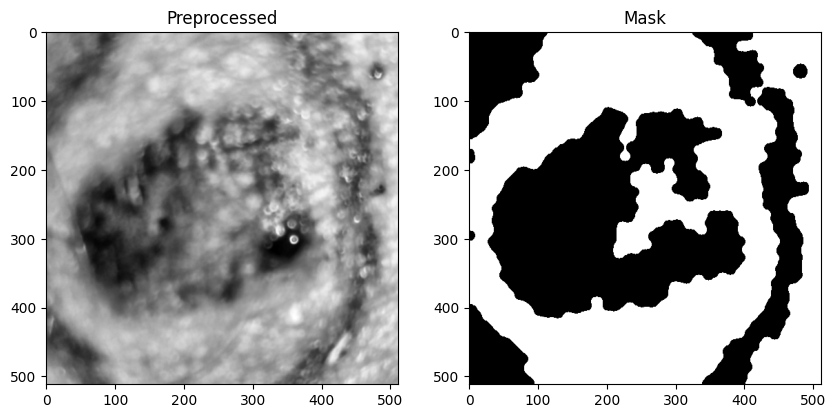

In [313]:
preprocessed_image = preprocess_image(image_path)
mask = create_mask(preprocessed_image)

# Display the mask side by side with the original image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(preprocessed_image, cmap="gray")
ax[0].set_title("Preprocessed")
ax[1].imshow(mask, cmap="gray")
ax[1].set_title("Mask")
plt.show()

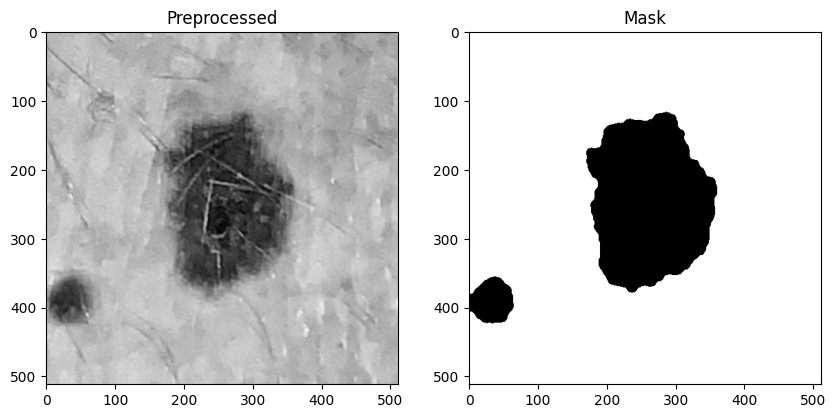

True

In [314]:
# Debugging code:
# load image PAT_333_1468_620 from the preprocessed images folder
image_path = "..\\data\\preprocessed_images\\PAT_333_1468_620.png"
mask = create_mask(cv2.imread(image_path))

# Display the mask side by side with the original image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
ax[0].set_title("Preprocessed")
ax[1].imshow(mask, cmap="gray")
ax[1].set_title("Mask")
plt.show()

# output the mask image to desktop
mask_uint8 = (mask * 255).astype(np.uint8)
cv2.imwrite("mask.png", mask_uint8)

In [317]:
def create_mask_util(input_folder, output_folder):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Loop through all files in input folder
    for filename in os.listdir(input_folder):
        # Load image
        img = cv2.imread(os.path.join(input_folder, filename))

        # Create mask
        mask = create_mask(img)

        # Save mask in output folder with same filename as input image
        mask_uint8 = (mask * 255).astype(np.uint8)
        cv2.imwrite(os.path.join(output_folder, filename), mask_uint8)

In [318]:
def create_mask_util(input_folder, output_folder):
    # Create output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Loop through all files in input folder
    for filename in os.listdir(input_folder):
        # Load image
        img = cv2.imread(os.path.join(input_folder, filename))
        print(f'Loaded image: {filename}, shape: {img.shape}')

        # Create mask
        mask = create_mask(img)
        print(f'Created mask for image: {filename}, mask shape: {mask.shape}')

        # Save mask in output folder with same filename as input image
        mask_uint8 = (mask * 255).astype(np.uint8)
        cv2.imwrite(os.path.join(output_folder, filename), mask_uint8)

In [338]:
input_folder = '..\\data\\shanon_training'
output_folder = '..\\data\\shanon_training_output'
create_mask_util(input_folder, output_folder)

Loaded image: PAT_1034_161_203.png, shape: (512, 512, 3)
Created mask for image: PAT_1034_161_203.png, mask shape: (512, 512)
Loaded image: PAT_1063_268_919.png, shape: (512, 512, 3)
Created mask for image: PAT_1063_268_919.png, mask shape: (512, 512)
Loaded image: PAT_1064_272_668.png, shape: (512, 512, 3)
Created mask for image: PAT_1064_272_668.png, mask shape: (512, 512)
Loaded image: PAT_109_868_113.png, shape: (512, 512, 3)
Created mask for image: PAT_109_868_113.png, mask shape: (512, 512)
Loaded image: PAT_109_868_723.png, shape: (512, 512, 3)
Created mask for image: PAT_109_868_723.png, mask shape: (512, 512)
Loaded image: PAT_113_172_610.png, shape: (512, 512, 3)
Created mask for image: PAT_113_172_610.png, mask shape: (512, 512)
Loaded image: PAT_115_1138_870.png, shape: (512, 512, 3)
Created mask for image: PAT_115_1138_870.png, mask shape: (512, 512)
Loaded image: PAT_1171_615_468.png, shape: (512, 512, 3)
Created mask for image: PAT_1171_615_468.png, mask shape: (512, 512

In [342]:
import os
import cv2

# Define the paths to the two folders
training_output_dir = '..\\data\\shanon_masks_corrected'
masks_dir = '..\\data\\shanon_masks'

# Loop through each mask in the masks folder
for filename in os.listdir(masks_dir):
    # Load the mask image
    mask_path = os.path.join(masks_dir, filename)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Reverse the mask
    mask = cv2.bitwise_not(mask)

    # Save the reversed mask in the training output folder with the same filename
    output_path = os.path.join(training_output_dir, filename)
    cv2.imwrite(output_path, mask)

Access how well the mask is working using dice coefficient:


In [348]:
# Set the paths to the two folders containing the masks
mask_dir = '..\\data\\shanon_training_output'
gt_dir = '..\\data\\shanon_masks_corrected'

# Get a list of all the mask filenames
mask_filenames = os.listdir(mask_dir)

# Initialize a variable to store the total Dice coefficient
total_dice_coefficient = 0.0

# Loop over all the mask filenames
for filename in mask_filenames:
    # Load the mask and groundtruth images
    mask_path = os.path.join(mask_dir, filename)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    gt_path = os.path.join(gt_dir, filename)
    gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

    # Compute the dice coefficient between the mask and groundtruth
    intersection = np.logical_and(mask, gt)
    dice_coefficient = 2.0 * intersection.sum() / (mask.sum() + gt.sum())

    # Add the dice coefficient to the total
    total_dice_coefficient += dice_coefficient
    
    print(f"Filename: {filename}, Dice coefficient: {dice_coefficient}")

# Compute the average Dice coefficient
average_dice_coefficient = total_dice_coefficient / len(mask_filenames)

print(f"Average Dice coefficient: {average_dice_coefficient}")


Filename: PAT_1034_161_203.png, Dice coefficient: 0.0024281453450053607
Filename: PAT_1063_268_919.png, Dice coefficient: 0.0009651347230345675
Filename: PAT_1064_272_668.png, Dice coefficient: 0.0026638298294313846
Filename: PAT_109_868_113.png, Dice coefficient: 0.003823643608424694
Filename: PAT_109_868_723.png, Dice coefficient: 0.003826948648191343
Filename: PAT_113_172_610.png, Dice coefficient: 0.0015859060346205388
Filename: PAT_115_1138_870.png, Dice coefficient: 0.002702508668127041
Filename: PAT_1171_615_468.png, Dice coefficient: 0.0021906685352060095
Filename: PAT_1245_845_32.png, Dice coefficient: 0.0029921940418086
Filename: PAT_1246_846_111.png, Dice coefficient: 4.778975587574204e-05
Filename: PAT_1298_1050_519.png, Dice coefficient: 0.0025938607044440716
Filename: PAT_131_197_974.png, Dice coefficient: 0.0025925303687077193
Filename: PAT_1392_1352_778.png, Dice coefficient: 0.0024962270889554994
Filename: PAT_1431_1495_931.png, Dice coefficient: 0.0020687050643503724


The average Dice coefficient of 0.002925423409080723 indicates a very poor overlap between the masks in the mask_dir directory and the corresponding groundtruth masks in the gt_dir directory. The Dice coefficient ranges from 0 to 1, where a value of 1 indicates a perfect overlap between the two masks, and a value of 0 indicates no overlap at all. Therefore, a value close to 0 suggests that the masks are not accurately capturing the groundtruth.

In [321]:
input_folder = '..\\data\\preprocessed_images'
output_folder = '..\\data\\masks'
create_mask_util(input_folder, output_folder)

Loaded image: PAT_1000_31_620.png, shape: (512, 512, 3)
Created mask for image: PAT_1000_31_620.png, mask shape: (512, 512)
Loaded image: PAT_1006_53_385.png, shape: (512, 512, 3)
Created mask for image: PAT_1006_53_385.png, mask shape: (512, 512)
Loaded image: PAT_1006_53_716.png, shape: (512, 512, 3)
Created mask for image: PAT_1006_53_716.png, mask shape: (512, 512)
Loaded image: PAT_1008_59_297.png, shape: (512, 512, 3)
Created mask for image: PAT_1008_59_297.png, mask shape: (512, 512)
Loaded image: PAT_100_393_595.png, shape: (512, 512, 3)
Created mask for image: PAT_100_393_595.png, mask shape: (512, 512)
Loaded image: PAT_100_393_898.png, shape: (512, 512, 3)
Created mask for image: PAT_100_393_898.png, mask shape: (512, 512)
Loaded image: PAT_1013_82_876.png, shape: (512, 512, 3)
Created mask for image: PAT_1013_82_876.png, mask shape: (512, 512)
Loaded image: PAT_1014_85_22.png, shape: (512, 512, 3)
Created mask for image: PAT_1014_85_22.png, mask shape: (512, 512)
Loaded ima

ValueError: attempt to get argmax of an empty sequence

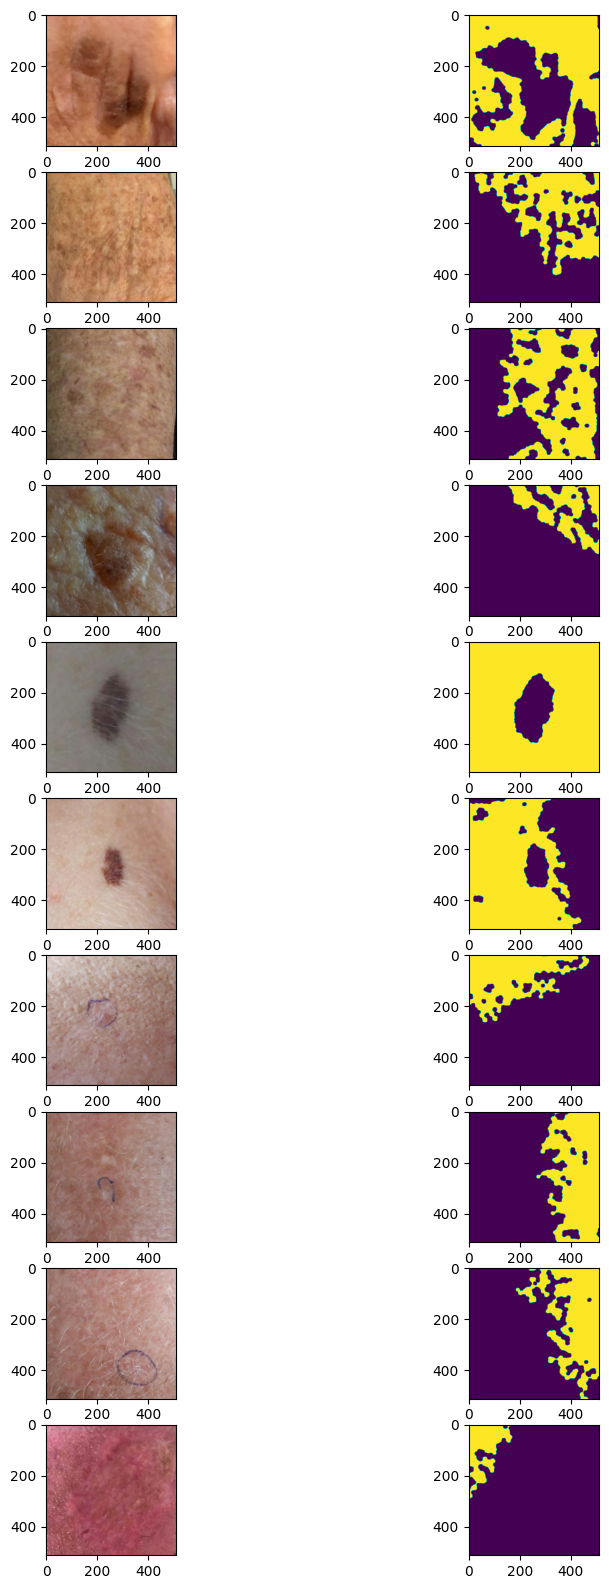

In [294]:
# Set the folders containing the images
folder_left = "..\\data\\images_resized"
folder_right = "..\\data\\masks"

# Get a list of the image files in the folder_left
image_files = os.listdir(folder_left)
# Sort the list alphabetically to ensure that the files are paired correctly
image_files.sort()

# Set the number of pairs to display
num_pairs = 10

# Set up the subplots
fig, axes = plt.subplots(num_pairs, 2, figsize=(10, 20))

# Loop through the pairs and display them side by side
for i in range(num_pairs):
    # Load the left and right images
    left_image_path = os.path.join(folder_left, image_files[i])
    right_image_path = os.path.join(folder_right, image_files[i])
    left_image = Image.open(left_image_path)
    right_image = Image.open(right_image_path)
    
    # Display the left and right images side by side
    axes[i, 0].imshow(left_image)
    axes[i, 1].imshow(right_image)
    
# Display the plot
plt.show()

In [295]:
# Set path to CSV file
csv_file = "..\\data\\metadata.csv"

# Create empty dictionary to store img_id and diagnostic
img_id_diagnostic = {}

# Open CSV file and read rows
with open(csv_file, "r") as f:
    reader = csv.reader(f)

    # Skip first line
    next(reader)

    # Iterate over rows and store img_id and diagnostic in dictionary
    for row in reader:
        img_id = row[24]  # 23rd column
        # print it
        # print(img_id)
        diagnostic = row[17]  # 18th column
        # print(diagnostic)
        img_id_diagnostic[img_id] = diagnostic

In [296]:
seed = 42
random.seed(seed)

# remove all pairs in img_id_diagnostic, where value is not NEV
for key in list(img_id_diagnostic.keys()):
    if img_id_diagnostic[key] != "MEL":
        del img_id_diagnostic[key]

# select 10 random keys from img_id_diagnostic and store them in a list
random_keys = random.sample(list(img_id_diagnostic.keys()), 20)
print(random_keys)

['PAT_719_1361_160.png', 'PAT_115_1138_870.png', 'PAT_995_1867_5.png', 'PAT_115_1138_970.png', 'PAT_884_1683_538.png', 'PAT_433_852_20.png', 'PAT_975_1834_152.png', 'PAT_895_1699_872.png', 'PAT_340_714_68.png', 'PAT_270_417_728.png', 'PAT_614_1166_885.png', 'PAT_972_1843_756.png', 'PAT_656_1246_483.png', 'PAT_966_1825_584.png', 'PAT_320_681_410.png', 'PAT_233_354_828.png', 'PAT_746_1407_708.png', 'PAT_890_1693_454.png', 'PAT_70_107_591.png', 'PAT_754_1429_380.png']


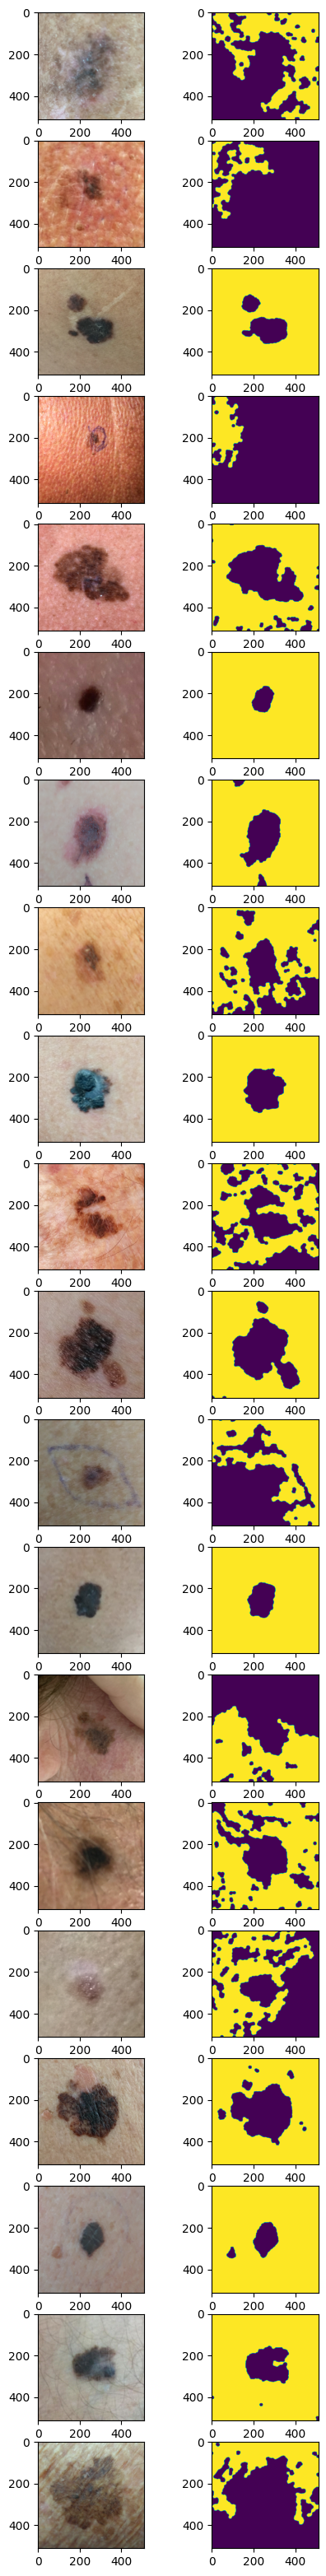

In [298]:
# Set the folders containing the images
folder_left = "..\\data\\images_resized"
folder_right = "..\\data\\masks"

# Set the number of pairs to display
num_pairs = len(random_keys)

# Set up the subplots
fig, axes = plt.subplots(num_pairs, 2, figsize=(5, 40))

# Loop through the pairs and display them side by side
for i in range(num_pairs):
    # Load the left and right images
    left_image_path = os.path.join(folder_left, random_keys[i])
    right_image_path = os.path.join(folder_right, random_keys[i])
    # display un-modified images
    axes[i, 0].imshow(Image.open(left_image_path))
    axes[i, 1].imshow(Image.open(right_image_path))
    
# Display the plot
plt.show()